In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from pathlib import Path
import gzip, os
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from streaming import MDSWriter
import json
import shutil

In [43]:
json_folder = '/disk/10tb/home/fishman/DNALM/GENA_LM/data/pretrain/mnt/nfs_dna/shadskiy/promoters/split_data_new/valid/'
jsons = []
jsonfiles = os.listdir(json_folder)
print (len(jsonfiles))
file = jsonfiles[0]
keys = ['text', 'promoter_strand', 'transcript_strand', 'position',
 'transcript_ID',  'gene_ID', 'transcript_type', 'chromosome','genome']
with open(os.path.join(json_folder, file), 'r') as f:
	for line in f:
		j = json.loads(line)
		assert all(key in j for key in keys)
		jsons.append(j)
jsons[0]

447


{'text': ['ACAATGTCAGAAGCTTTATCAGAGGTCAACTTAAGTCACTCTTTATAAAAGGAAATGGAAGGGAGGAAGGGAGAGAGGCTGGTGAAGAAGTCTGAAAGGAGACCGACCTACACCCTGGGTGAGATTGGATGGGTTAAGGGTCTCTGGCACTATCTGTCTTCACTATTGATAGCACACAACCCACCACACGACGCCTGTCTCTGAATGGCGAAGCTAGAATGCAAGTCAAGGGTATTAATAGAGAAAACAACTAGCATCCCGGCAACATCAAAACCAACCCCCTCCTTTACTTAAACATTCAATGCAGATCCGGAATCGATTGGGCCACTTTACCCAAACCGTTTTAAAACTCCCCATTACGTTTTACATGCCACAACGGCGCTTAAGAAATCAGACCAGGATTCCTTCTGCTTTGACACACGGAGAATAACTGAATGCTTGTACTGACAGATGCACAAGTTCTTCTTTCTTACCTGCAACTTTAACCGGATGTTCATGTTCATCAGTTCAGACTAGGAAGTCTGACAATCAGAAATGATAATTAGAGGCAGCCAAGCAGCAGGACTAGCCCTCCTCAGCCCTCGTGGAGCCGGAGCCCCGGTAGGCTGCCGCCATTAGGCCCAGCTGATGGGATGCCAACAGCAGCAGCGTCCCTTGACGAGAGTGCAGCCCTGGCCCCTCCCTCCCCCAGTCTCCCCCCCTCCCACCCAGGTGCTATCCTTAGTTTACTGACTTATACCTCAGGGATGGAAACATGTACTCCCCCCCCATCCCTTTTCTGATGGTTGTAAGGGCAGCTTTTTCCTTAGCATACATGGGAGGCGTTGGTAAAACAACCGCTACTCATTCCAGCGCAGCCTGATAGCTGACGTCTCCATCCAAATATCAGCTCAGGAAATCACGCCTGACGGAGAGAAACCCCTTCTCTAAACCTCTCCGGTAAGACCCCTGCGTGTCCTGAGCCCTGGGCAACTTATTTTACTTGGCAG

In [38]:
min_len = 1000
chunk_len = 37000

In [54]:
chunks = []
chunks_lengths = []
split_name = "valid"
columns = {"text": "str",
		   "file_id": "str",
		   "line_id": "int",
		   }
out_dir = '/disk/10tb/home/fishman/DNALM/ModernBERT/data/promoters_mds/'
out_dir = out_dir + "/" + split_name
overwrite = True

if os.path.exists(out_dir):
	if overwrite:
		shutil.rmtree(out_dir)
	else:
		raise ValueError("Output directory already exists. Set overwrite to True to delete the content of the directory.")
os.makedirs(out_dir)

with MDSWriter(columns=columns, out=out_dir, size_limit='64mb') as fout:
	for file in tqdm(jsonfiles):
		with open(os.path.join(json_folder, file), 'r') as f:
			for line_id,line in enumerate(f):
				j = json.loads(line)
				assert all(key in j for key in keys)
				text = j['text']
				assert len(text) == 1, "Multiple text items for file " + file
				text = text[0]
				for i in range(0, len(text), chunk_len):
					chunk = text[i:i+chunk_len]
					if len(chunk) > min_len:
						fout.write({'text': str(chunk).upper(),
										"file_id": file.split('.')[0], 
										"line_id": line_id
										}
									)
						chunks_lengths.append(len(chunk))

100%|██████████| 447/447 [1:01:08<00:00,  8.21s/it]


In [48]:
!ls '/disk/10tb/home/fishman/DNALM/ModernBERT/data/promoters_mds/valid_full/'

index.json  shard.00000.mds  shard.00001.mds  shard.00002.mds  shard.00003.mds


In [10]:
pd.Series(chunks_lengths).value_counts()

36864    19084
36764      226
36664       41
36364       30
36851       27
         ...  
9929         1
16615        1
25375        1
29656        1
8619         1
Name: count, Length: 227, dtype: int64

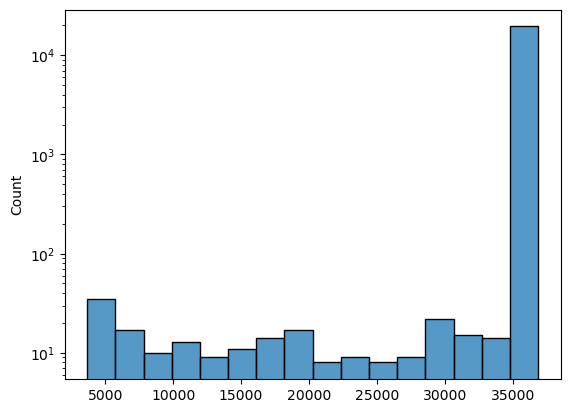

In [13]:
sns.histplot(chunks_lengths)
plt.yscale('log')
plt.show()

In [15]:
split_name = "valid"

In [16]:
from streaming import MDSWriter
columns = {"text": "str",
		   "file_id": "str",
		   "line_id": "int",
		   }
out_dir = '/disk/10tb/home/fishman/DNALM/ModernBERT/data/promoters_mds/'
if not os.path.exists(out_dir):
	os.makedirs(out_dir)	
with MDSWriter(columns=columns, out=f'{out_dir}/{split_name}', size_limit='64mb') as fout:
	for sample in tqdm(chunks, total=len(chunks), desc=split_name):
		fout.write(sample)

valid:   0%|          | 0/19658 [00:00<?, ?it/s]

valid: 100%|██████████| 19658/19658 [00:01<00:00, 11210.49it/s]
